<a href="https://colab.research.google.com/github/microprediction/winning/blob/main/synonyms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install winning
!pip install pandas
!pip install scipy
!pip install nevergrad
!pip install powerlaw
!pip install PyDictionary
!pip install wordfreq
from pprint import pprint
import powerlaw
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends
import numpy as np 
import pylab 
import scipy.stats as stats 
import pandas as pd 
from winning.skew_calibration import skew_dividend_implied_ability, skew_ability_implied_dividends, state_price_implied_ability
import numpy as np 
import pylab 
from winning.lattice import center_density, skew_normal_density
from winning.lattice_conventions import ALT_UNIT, ALT_L, ALT_SCALE, ALT_A
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import norm
import math 
from PyDictionary import PyDictionary
from wordfreq import word_frequency
dictionary = PyDictionary()

In [10]:
def normalize(x):
  x_sum = np.sum(x)
  return [xi/x_sum for xi in x]

def standardize(x):
    xc = [xi-np.mean(x) for xi in x]
    xs = [xci/np.std(xc) for xci in xc ] 
    return xs 

def ability_transform(x,a,cull=1):
    sx = list(reversed(sorted(x)))
    nzx = [ x_ for x_ in sx if x_>0 ][cull:-cull]  # Chop highest and lowest
    z = normalize(nzx)
    zt = [ max(zi,0.00000000005) for zi in z] # Instability - need to look into this or increase lattice
    density = skew_normal_density(L=2*ALT_L, unit=ALT_UNIT, loc=0., scale=ALT_SCALE, a=a)
    ability = state_price_implied_ability(prices=zt, density=density)
    return standardize(ability) 

def proximity(x,a):
    sa = ability_transform(x,a)
    cdfs = [ stats.norm.cdf(sai) for sai in sa ]
    n = len(cdfs)
    std_cdfs = np.linspace(1/(n+1),1-1/(n+1),n)
    return np.mean([ abs(c1-c2) for c1,c2 in zip(sorted(cdfs),std_cdfs)])

def ability_fit(x):
    """
       Finds the skew best matching the distribution
    """
    def objective(a):
      return proximity(x,a)

    result = minimize(objective, x0=[0], bounds=[(-3,3)],options={'maxiter':100})
    best_a = result.x.tolist()[0] 

    return best_a
    
def ability_plot(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   f = stats.probplot(y, dist="norm", plot=pylab)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)
   pylab.show()
   return f

def ability_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   plt.hist(y,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def ability_log_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   y_min = np.min(y)
   y_shift = [yi+y_min+1.0 for yi in y]
   plt.hist(y_shift,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)

def neg_ability_log_hist(x,a=0.0,cull=1,title=None,offset=1.0):
   y = ability_transform(x,a,cull=1)
   y_max = np.max(y)
   y_shift = [y_max-yi+offset for yi in y]
   plt.hist(y_shift,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)
   
def log_hist(x,a=0.0,cull=1,title=None):
   y = ability_transform(x,a,cull=1)
   plt.hist(y,bins=50)
   if title is None:
     plt.title('a='+str(a))
   else:
     plt.title(title)
  
def log_norm_hist(x,a=0.0,cull=1,title=None,offset=1.0):
   x_min = np.min(x)
   x_shift = [xi-x_min+offset for xi in x]
   log_x = [math.log(xsi) for xsi in x_shift]
   plt.hist(log_x,bins=50)
   if title is None:
     plt.title('log normal')
   else:
     plt.title(title)

def log_norm_plot(x,a=0.0,cull=1,title=None,offset=1.0):
   x_min = np.min(x)
   x_shift = [xi-x_min+offset for xi in x]
   log_x = [-math.log(xsi) for xsi in x_shift]
   f = stats.probplot(log_x, dist="norm", plot=pylab)
   if title is None:
     plt.title('log normal')
   else:
     plt.title(title)
   pylab.show()

def manual_search(x):
   ajs = list(np.linspace(-4,4,50))
   prox = [proximity(x,aj) for aj in ajs ]
   plt.plot(ajs,prox)

def compare(data):
  """ test power law versus lognormal"""
  results = powerlaw.Fit(data)
  R, p = results.distribution_compare('power_law', 'lognormal')
  if R>0:
    print('probably power law')
  else:
    print('probably lognormal')
  pprint({'R':R,'p':p})
  return R,p




def synonym_plot(wd='mother',a=0.0):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  ability_plot(freqs,a=a,cull=0)

def synonym_logplot(wd='mother',offset=1.0):
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  log_norm_plot(freqs,offset=offset)
  
def synonym_hist(wd='mother',a=0.0):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  ability_hist(freqs,a=a,cull=0)

def synonym_loghist(wd='mother',offset=0.1):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  log_norm_hist(freqs,offset=offset)

def synonym_pdf(wd='mother'):
  """  Ability plot of synomyns for any word
  """
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  nz = [ f for f in freqs if f>0]
  powerlaw.plot_pdf(nz)

def synonym_compare(wd):
  # fixme
  wd_synonyms = dictionary.synonym(wd)
  freqs = [ word_frequency(w,'en') for w in wd_synonyms]
  return compare(freqs)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


probably lognormal
{'R': -0.22003127853089754, 'p': 0.6427348919683094}


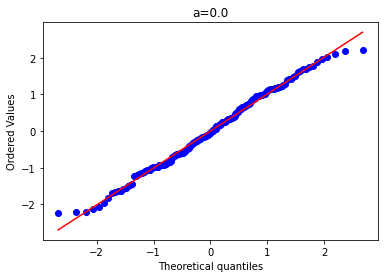

In [17]:
word = 'move'
synonym_compare(word) # 3rd party package 'opinion' on whether lognormal is actually better fit than power law
synonym_plot(word)